In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io as sio
from scipy import signal, stats

import tensorly as tl

concentrations = pd.read_table("../Acar_data/concentrations.txt", sep="\s+")
mat = sio.loadmat("../Acar_data/EEM_NMR_LCMS.mat")

# Data description

# Mixture concentrations

In [ ]:
print(concentrations.shape)
print((concentrations != 0).sum(axis=1).describe())

## Fluorescence Spectroscopy (Excitation Emission Matrix - EEM)

- 28 mixtures
- emission wavelength (mode 2)
- excitation wavelength (mode 3)

In [35]:
eem = mat["X"][0][0]["data"]

print(eem.shape)

(28, 251, 21)


## NMR spectra
- 28 mixtures
- chemical shifts (mode 2)
- gradient levels (mode 3)

In [4]:
nmr = mat["Y"][0][0]["data"]
print(nmr.shape)

(28, 13324, 8)


## LC-MS

Matrix n_mixtures x n_features

In [34]:
lcms = mat["Z"][0][0]["data"]

print(lcms.shape)

(28, 168)


# Tensor decomposition

In [5]:
ranks = range(1, 5)
errors = []
for rank in ranks:
    fac = tl.decomposition.parafac(nmr, rank=rank)
    err = tl.norm(tl.cp_to_tensor(fac) - nmr)
    errors.append(err)
errors = np.array(errors)

In [7]:
tl.cp_normalize(fac).shape

(28, 13324, 8)

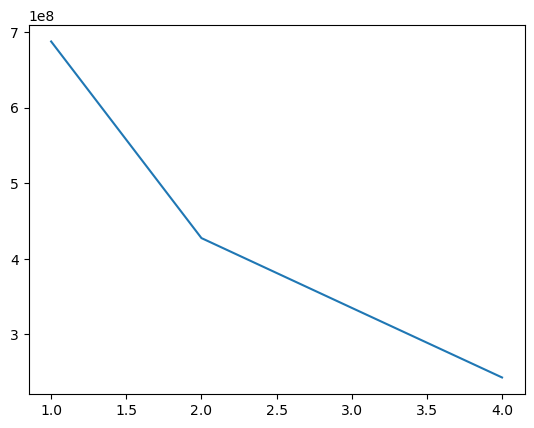

In [6]:
plt.plot(ranks, errors)

In [8]:
fac = tl.decomposition.parafac(nmr, rank=5)

In [31]:
((tl.cp_normalize(fac).factors[0] - concentrations.values)**2).mean(1)

array([ 4.92424847,  4.96131763,  5.59500258,  4.57738932,  5.0000394 ,
       10.77521404,  8.94934433,  7.80507425, 11.49268384, 11.27509594,
        9.29045889, 10.72065259, 10.9893765 , 11.22704515,  6.44270741,
       10.18194881, 11.1929902 ,  7.06053594,  8.71759692,  4.66166814,
        7.7861479 , 10.85999792,  7.89516006,  7.22191643,  2.92751168,
       10.65233541,  9.86767927,  8.02394909])